## Labeling EEG Data

The first step in the process is to label the EEG data for facetouches using the video recording. This can be done quite precisely using OpenCV. First, the files for both the video recording and EEG recording must be loaded

In [1]:
import cv2
import numpy as np
from datetime import *
import time
import pandas as pd
import matplotlib.pyplot as plt

In order create labels as accurtely as possible, we need to calculate the UNIX timestamp corresponding to each video frame. To do this, we convert the Zoom timestamp to UNIX time, and calculate the time delta for each frame using the video's framerate. From here, we can calculate the start time and end time of the video

In [2]:
def load_video(video_path):

    # Load video file
    video = cv2.VideoCapture(video_path)

    # Get video timestamp from folder name
    video_time = video_path.split('/')[-2].split(' ')[:2]
    video_time = [int(x) for x in video_time[0].split('-')] + [int(x) for x in video_time[1].split('.')]
    video_time = datetime(video_time[0], video_time[1], video_time[2], video_time[3], video_time[4], video_time[5])

    # Convert to UNIX timestamp
    video_start_time = video_time.timestamp()

    # Get framerate of video, and calculate end time
    fps = video.get(cv2.CAP_PROP_FPS)
    video_time_delta = 1. / fps
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video_end_time = video_start_time + total_frames*video_time_delta

    print("Video Start Time:",video_start_time)
    print("Video End Time:  ",video_end_time)
    print("Video FPS:\t ",fps)
    print("Total Frames:\t ",total_frames)
    
    return video, video_start_time, video_end_time, total_frames, video_time_delta

Next, we get similar information for the EEG data. This is much simpler, as each frame of EEG data is labeled with a UNIX timestamp to begin with.

In [3]:
def load_eeg(eeg_path):

    # Load EEG recording file
    eeg_df = pd.read_csv(eeg_path)

    # Get UNIX time start time for EEG data
    eeg_start_time = eeg_df['timestamps'].iloc[0]
    eeg_end_time = eeg_df['timestamps'].iloc[-1]
    total_frames = eeg_df.shape[0]

    print("EEG Start Time:\t",eeg_start_time)
    print("EEG End Time:\t",eeg_end_time)
    print("Total Frames:\t",total_frames)
    
    return eeg_df, eeg_start_time, eeg_end_time, total_frames

In [24]:
# Declare filepaths for video and eeg recording files
video_path = "./EEG data/Videos/2020-04-16 14.52.56 Tom Yeh_s Personal Meeting Room 5191522377/zoom_0.mp4"

jack_eeg_path = ""
shawn_eeg_path = "EEG data/EEG_shawn_5_mins_reading_news.csv"
xu_eeg_path = "EEG data/read_news_Xu.csv"

# CHOOSE PERSON TO LABEL
eeg_path = xu_eeg_path

video, video_start_time, video_end_time, video_frames, video_time_delta = load_video(video_path)
print()
eeg_df, eeg_start_time, eeg_end_time, eeg_frames = load_eeg(eeg_path)

Video Start Time: 1587070376.0
Video End Time:   1587070681.64
Video FPS:	  25.0
Total Frames:	  7641

EEG Start Time:	 1587070390.6339998
EEG End Time:	 1587070688.9420002
Total Frames:	 76368


Now that we have the necessary timestamp data for both the Video and EEG frames, we can label each EEG frame corresponding to whether or not the subject is touching their face in the corresponding video frame. The below script utilized OpenCV to achieve this. While watching a playback of the video at reduced speed, each time the spacebar is pressed, the script will begin labeling the corresponding EEG frames as a face touch event. Once the spacebar is pressed again, the labeling is stopped. Once the whole video has been played, a dataframe is saved which contains each frame of the EEG recording that occurs within the video's timespan, labeled with a binary value for facetouch events. It also saves the total number of individual face touching events, as well as frame markers for each event.

In [5]:
current_video_time = video_start_time
current_eeg_time = eeg_start_time

current_video_frame = 0
current_eeg_frame = 0

label = False
event_count = 0
event_frames = []

# Initialize dataframe for labeled EEG data
eeg_labeled = pd.DataFrame(columns = eeg_df.columns.to_list() + ['facetouch'])

# Loop through frames of video recording
while video.isOpened():
    
    # Grab video frame
    ret,frame = video.read()

    # If the UNIX timestamp of the current video frame is within the EEG recording's timespan
    if current_video_time >= eeg_start_time and current_video_time <= eeg_end_time:
        
        # Grab all EEG frames corresponding to the current video frame, and label
        num_eeg_frames = 0
        while current_eeg_time < current_video_time:

            current_eeg_time = eeg_df['timestamps'].iloc[current_eeg_frame]

            row = eeg_df.iloc[current_eeg_frame]
            
            row['facetouch'] = label
            eeg_labeled = eeg_labeled.append(row)

            num_eeg_frames += 1
            current_eeg_frame += 1
        
        # Process user input
        key = cv2.waitKey(1) & 0xFF
        
        # 'q' for quit, spacebar to toggle EEG frame labeling
        if key == ord('q'):
            break
        elif key == ord(' '):
            label = not label
            event_count += label
            if label:
                event_start = current_eeg_frame
            else:
                event_frames.append((event_start, current_eeg_frame))

        if label:
            cv2.putText(frame, 'FACE TOUCH', (50,50), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 2, cv2.LINE_AA)

        cv2.imshow('window-name',frame)

    current_video_time += video_time_delta
    current_video_frame += 1
    
video.release()
cv2.destroyAllWindows()

# Save dataframe and event markers in hd5f file
store = pd.HDFStore(eeg_path[:-4] + '_labeled.hdf5')
store.put('eeg_labeled', eeg_labeled)
metadata = {'event_count':event_count,'event_frames':event_frames}
store.get_storer('eeg_labeled').attrs.metadata = metadata
store.close()

We can load the resulting dataframe and see how many individual frames of face-touching we have, and view the frames of each event

In [5]:
label_path = "EEG data/EEG_shawn_5_mins_reading_news_labeled.hdf5"
#label_path = eeg_path[:-4] + '_labeled.hdf5'

with pd.HDFStore(label_path) as store:
    labeled_data = store['eeg_labeled']
    metadata = store.get_storer('eeg_labeled').attrs.metadata

print('Total EEG frames: %d Facetouch frames: %d'
      %(labeled_data.shape[0], labeled_data[labeled_data['facetouch'] == True].shape[0]))
print('%d Face-touching events at\n'%(metadata['event_count']),np.array(metadata['event_frames']))

Total EEG frames: 64464 Facetouch frames: 3512
12 Face-touching events at
 [[ 2696  2891]
 [10632 10909]
 [13592 13899]
 [20821 20944]
 [23627 23975]
 [26525 26996]
 [27150 27528]
 [31379 31655]
 [37891 37912]
 [38823 39100]
 [43503 43994]
 [54183 54531]]


## Preparing data for training

Now, we must prepare the dataset for training with an LSTM Recurrent Neural Network. First, we grab example windows of both events and non-events. The length of the window is a variable we can adjust to see how it affects the training. To start off with, a window length of 256 frames (corresponding to one second of EEG recording) is reasonable. We can select the frames such that the face touching event occurs exactly halfway through the window. We can artificially increase the size of the dataset by choosing 4 random offset values for each face touch event.

In [9]:
# Hyperparameters
WINDOW_LENGTH = 256 # Number of EEG frames per sample window
NUM_OFFSETS = 4     # Number of different offsts for each training sample for data augmentation

offsets = np.random.randint(int(WINDOW_LENGTH/5), WINDOW_LENGTH-int(WINDOW_LENGTH/5), 4)

eeg_data = labeled_data.to_numpy()[:,1:5]
eeg_labels = labeled_data.to_numpy()[:,6]
event_frames = metadata['event_frames']

X = np.zeros(((len(event_frames)*2)*len(offsets),WINDOW_LENGTH,eeg_data.shape[1]))
y = np.zeros((X.shape[0],1))

count=0
# Get face touching event windows
for i,event in enumerate(event_frames):
    for j in range(NUM_OFFSETS):
        
        # Calculate random offset between 0.2 and 0.8 window length
        offet = np.random.randint(int(WINDOW_LENGTH/5), WINDOW_LENGTH-int(WINDOW_LENGTH/5))
        start = event[0] - offset
        
        # Grab WINDOW_LENGTH frame starting at offset
        window = eeg_data[start:start+WINDOW_LENGTH]
        X[count] = window
        y[count] = 1
        count += 1

# Get non-facetouching event windows
eeg_data_rest = eeg_data[eeg_labels == 0]
for j in range(len(event_frames)):
    start = np.random.randint(0,eeg_data_rest.shape[0]-WINDOW_LENGTH)
    window = eeg_data_rest[start:start+WINDOW_LENGTH]
    X[count+j] = window
    y[count+j] = 0

print('Training data shape: ',X.shape)

Training data shape:  (96, 256, 4)


By using 4 random offset values, we end up with a final training dataset of 96 samples. Each sample contains 256 time steps for each of the 4 EEG channels

## Training with an LSTM

Next, we can load the training dataset into a simple LSTM network using the python Keras framework. Because the training dataset is so small, an LSTM with only 50 hidden nodes is chosen, and one fully connected layer. LSTM networks are good for identifying sequences, so in theory given enough training data, if there is in fact information encoded within EEG data to predict face-touches, an LSTM should be able to extract it if trained and designed properly.

LSTM networks differ from regular neural networks in that they include feedback within the hidden layers. This gives them the ability to "remember" features of sequences. Each training example is fed through the network sequentially, so each individual time step influences the output differently depending on where it is found in the sequence

![title](bptt.png)

First, we split the dataset into a training and validation set, with a split of 90/10. This is made very simple using sklearn's split functionality

In [11]:
# Perform train/test split with sklearn - code adapted from https://github.com/Cerebro409/EEG-Classification-Using-Recurrent-Neural-Network

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Keras makes it extremely simple to define and train simple neural network models. Here we define a neural network with one LSTM module with 50 hidden layers, and one fully connected layer for the final classification. Then, training the network is simply a matter of calling the model.fit() function.

In [12]:
# Training with simple keras model - code adapted from https://github.com/Cerebro409/EEG-Classification-Using-Recurrent-Neural-Network

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


n_features = 4  # EEG channels
time_steps = WINDOW_LENGTH

model = Sequential()
model.add(LSTM(60, return_sequences=False, input_shape=(time_steps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=2, epochs=15)
score = model.evaluate(X_test, y_test, batch_size=2)

print("Test set loss: %f accuracy %.2f%%"%(score[0], score[1]*100))

Epoch 1/15
86/86 [==============================] - 3s 38ms/step - loss: 0.5448 - accuracy: 0.7209
Epoch 2/15
86/86 [==============================] - 3s 32ms/step - loss: 0.3398 - accuracy: 0.8140
Epoch 3/15
86/86 [==============================] - 3s 32ms/step - loss: 0.2987 - accuracy: 0.8605
Epoch 4/15
86/86 [==============================] - 3s 33ms/step - loss: 0.3002 - accuracy: 0.8605
Epoch 5/15
86/86 [==============================] - 3s 33ms/step - loss: 0.2295 - accuracy: 0.9186
Epoch 6/15
86/86 [==============================] - 3s 33ms/step - loss: 0.2459 - accuracy: 0.9302
Epoch 7/15
86/86 [==============================] - 3s 33ms/step - loss: 0.2030 - accuracy: 0.9186
Epoch 8/15
86/86 [==============================] - 3s 32ms/step - loss: 0.2094 - accuracy: 0.9186
Epoch 9/15
86/86 [==============================] - 3s 32ms/step - loss: 0.2170 - accuracy: 0.8953
Epoch 10/15
86/86 [==============================] - 3s 33ms/step - loss: 0.1973 - accuracy: 0.9302
Epoch 11/

Using pyplot, we can visualize the loss and accuracy of the network during training

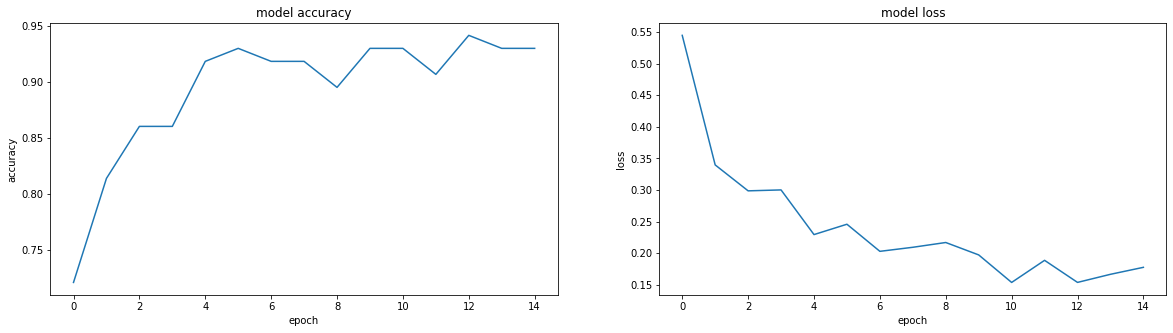

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 5))

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')

ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

## Testing on new data

Now that the model has been trained, it's time to test it on a new dataset. To do this, we can load a new set of video and EEG files from a different session, the same way as before

In [19]:
# Declare filepaths for video and eeg recording files
video_path = "EEG data/Videos/2020-04-16 15.21.20 Tom Yeh_s Personal Meeting Room 5191522377/zoom_0.mp4"

jack_eeg_path = ""
shawn_eeg_path = "EEG data/EEG_shawn_2_min_watching_up.csv"
xu_eeg_path = "EEG data/read_news_Xu.csv"

# CHOOSE PERSON TO LABEL
eeg_path = shawn_eeg_path

video, video_start_time, video_end_time, video_frames, video_time_delta = load_video(video_path)
print()
eeg_df, eeg_start_time, eeg_end_time, eeg_frames = load_eeg(eeg_path)

Video Start Time: 1587072080.0
Video End Time:   1587072267.0
Video FPS:	  25.0
Total Frames:	  4675

EEG Start Time:	 1587072115.603
EEG End Time:	 1587072234.99
Total Frames:	 30564


Since the model only cares about EEG data as input, we can split the EEG file into windows of the same length used to train, and predict each frame using the model.predict() functionality

In [20]:
eeg_evaluate = eeg_df.to_numpy()
num_windows = int(eeg_evaluate.shape[0] / WINDOW_LENGTH)

X_eval = np.zeros((num_windows,WINDOW_LENGTH,4))
timestamps = np.zeros(num_windows)

for i in range(num_windows):
    start = i*WINDOW_LENGTH
    finish = start + WINDOW_LENGTH
    X_eval[i] = eeg_evaluate[start:finish,1:5]
    timestamps[i] = eeg_evaluate[start,0]
    
y_eval = model.predict(X_eval)

The following code is similar to the original labeling code, except instead of finding the EEG data associated weith each video frame, it finds the video frames associated with each EEG window that has been labeled by the model. If the model predicts a face touch, it writes the event over the corresponding video frames, then saves a new video labeled with the predicted face touches

In [21]:
current_video_time = video_start_time
current_eeg_time = eeg_start_time

current_video_frame = 0
current_eeg_frame = 0
current_eeg_window = 0

label = False
event_count = 0
event_frames = []

width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT) # float
size = (int(width),int(height))
out = cv2.VideoWriter('prediction.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 25, size)

# Loop through frames of video recording
while video.isOpened():
    
    # Grab video frame
    ret,frame = video.read()

    # If the UNIX timestamp of the current video frame is within the EEG recording's timespan
    if current_video_time >= eeg_start_time:
        
        current_label = y_eval[current_eeg_window]
        
        if current_label >= 0.5:
            cv2.putText(frame, 'FACE TOUCH - %.2f%% CONFIDENCE'%(current_label*100), (50,50), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 2, cv2.LINE_AA)
        #cv2.imshow('window',frame)
        out.write(frame)

    current_video_time += video_time_delta
    current_video_frame += 1
    
    cv2.waitKey(1)
    
    if current_video_time > timestamps[current_eeg_window + 1]:
        current_eeg_window += 1
    if current_eeg_window+1 >= y_eval.shape[0] or current_video_time >= eeg_end_time:
        break
    
video.release()
out.release()
cv2.destroyAllWindows()

In [19]:
from IPython.display import Video

Video('prediction.mp4','mp4')

## Analysis/Conclusions

The algorithm seems to perform somewhat well some of the time, but has a lot of false positives and false negatives. The main issue, as with any deep learning project, is the lack of a sufficiently large and generalized dataset. Not much can be said about the viability of this project as a whole without many orders of magnitude more data.

Secondly, while the model does sometimes accurately classify a face touch event, it does not do much in the way of *predicting* a face touch event. With the theoretical optimal performance of the model demonstrated above, face touches would be predicted with in a time frame of 0.2-0.8 seconds before the touch occurred. Much more experimentation is required to determine whether this is enough to interact with the user and prevent the event from happening.

Thirdly, because my EEG recording failed, a live test with a stream of EEG data was not possible. This would further complicate the predictive capabilities of the model, as only the immediately previous 256 EEG frames can be fed into the network for prediction, and the model may only be successful if the touch itself occurs within these 256 frames